In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, cross_val_score, GridSearchCV
from sklearn.metrics import pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier

In [54]:
plt.style.use('seaborn')

Возьмем данные о заголовках веб-страниц, которые использовали до этого в домашней работе

In [3]:
doc_to_title = {}
with open('docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print(len(doc_to_title))

28026


Получим информацию о группах веб-страниц

In [5]:
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    for k, (doc_id, title, target_id) in enumerate(docs):
        groups_train.append(new_group)
groups_train = np.array(groups_train)
print(groups_train.shape)

(11690,)


Добавим нулевой документ для удобства работы

In [9]:
doc_to_title[0] = ''

Переведем строчку в список слов

In [10]:
doc_to_title_list = {id_: title.lower().split()
                     for id_, title in doc_to_title.items()}

Произведем векторизацию

In [16]:
tfidf_vectorizer = TfidfVectorizer()

lst = [' '.join(doc_to_title_list[i]) for i in range(len(doc_to_title_list))]

doc_tfidf = tfidf_vectorizer.fit_transform(lst)

doc_tfidf.shape

(28027, 41736)

Непосредственно приготавливаем наши признаки, которые представляют косинусное расстояние до 20 ближайших документов

In [38]:
df = pd.read_csv('train_groups.csv')
groups = df.groupby('group_id')
global_index = 0
X = np.empty((df.shape[0], 20), dtype=float)
y = np.empty(df.shape[0], dtype=float)
for group_id, group_index in groups.groups.items():
    size_of_group = group_index.size
    group = (df.iloc[group_index])
    for index, distances in enumerate(pairwise_distances(doc_tfidf[group.doc_id], metric='cosine')):
        X[global_index + index] = sorted(distances)[1:21]
    y[global_index:size_of_group+global_index] = group.target
    global_index += size_of_group
X.shape, y.shape

((11690, 20), (11690,))

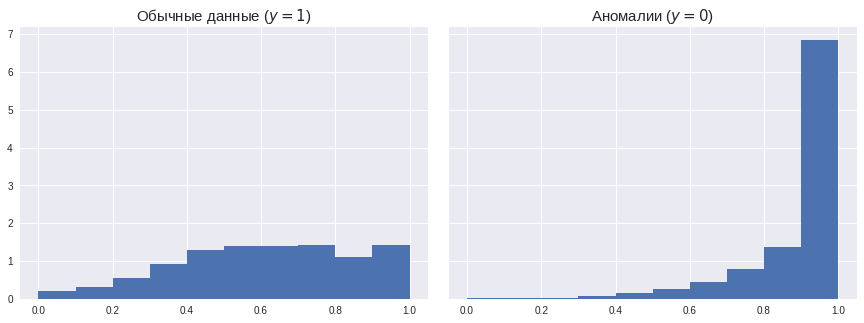

In [99]:
fig, axes = plt.subplots(1, 2, sharey=True)
fig.set_figheight(5)
fig.set_figwidth(15)
axes[0].hist(np.concatenate(X[np.where(y == 1)]), label='$y=1$', density=True)
axes[0].set_title('Обычные данные ($y=1$)', fontsize=15)
axes[1].hist(np.concatenate(X[np.where(y == 0)]), label='$y=0$', density=True)
axes[1].set_title('Аномалии ($y=0$)', fontsize=15)
plt.subplots_adjust(wspace=0.05)

Видно, распределения аболютно отличаются, а значит наши признаки позволят нам отличить информацию

Делаем тоже самое для тестовой части, разумеется, исключая таргет

In [60]:
df = pd.read_csv('test_groups.csv')
groups = df.groupby('group_id')
global_index = 0
count = 0
X_test = np.empty((df.shape[0], 20), dtype=float)
for group_id, group_index in groups.groups.items():
    size_of_group = group_index.size
    group = (df.iloc[group_index])
    for index, distances in enumerate(pairwise_distances(doc_tfidf[group.doc_id], metric='cosine')):
        X_test[global_index + index] = sorted(distances)[1:21]
    global_index += size_of_group
X_test.shape

(16627, 20)

Отнормируем наши данные

In [61]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X)

В качестве классификатора используем градиентный бустинг, который достаточно наивным образом попробуюм затюнить

In [62]:
param_grid_XGB = {'learning_rate': [.01, .03, .05, .1, .25],
                  'max_depth': [1, 2, 4, 6, 8, 10],
                  'n_estimators': [10, 50, 100, 300],
                  'seed': [0]}

xgb = XGBClassifier()

grid_search_xgb = GridSearchCV(xgb, param_grid_XGB, scoring=make_scorer(f1_score), cv=GroupKFold(
    n_splits=5))

grid_search_xgb.fit(X_train_scaled, y, groups=groups_train)

xgb_best = grid_search_xgb.best_estimator_

grid_search_xgb.best_params_

GridSearchCV(cv=GroupKFold(n_splits=5),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                 

Посмотрим качество f1 на валидации

In [67]:
cross_val_score(xgb_best, X_train_scaled, y, groups=groups_train,
                scoring=make_scorer(f1_score)).mean()

0.7197891267592494

Зафитим наши данные

In [68]:
xgb_best.fit(X_train_scaled, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

Отскалируем тест

In [69]:
X_test_scaled = scaler.transform(X_test)

Подготовим тестовые данные

In [70]:
test_data = pd.read_csv('test_groups.csv')
testgroups_titledata = {}
for i in range(len(test_data)):
    new_doc = test_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    title = doc_to_title[doc_id]
    if doc_group not in testgroups_titledata:
        testgroups_titledata[doc_group] = []
    testgroups_titledata[doc_group].append((doc_id, title))

In [71]:
def submit(clf):
    y_pred = clf.predict(X_test_scaled)

    y_pred = y_pred.astype(int)

    answer = pd.DataFrame({'pair_id': np.asarray(
        test_data['pair_id']), 'target': y_pred})

    answer = answer.set_index(['pair_id'])

    answer.to_csv('submission.csv')

Сабмитим резалт

In [27]:
submit(xgb_best)